# Load 20 newsgroup dataset

Alternativ auch nochmal mit sample_5000 probieren.

In [116]:

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
print(pd.Series(newsgroups_train['data']).str.split().apply(len).quantile(0.9))

508.0


# Cleaning

In [121]:
_input = fetch_20newsgroups(subset='train')['data']
_input = [dlutils.preprocess_document(x) for x in _input]
_input, vocab = dlutils.popularity_based_prefiltering(_input, min_df =0.00000001, max_df = 0.9999999, stopwords = dlutils.easy_stopwords())

1e-08 0.9999999
126496 words in the vocabulary


# Encoding
### Use max_seq_len = 512 for encoding the texts and a smaller max_seq_len to encode the words

In [122]:
from bert_serving.client import BertClient
bc = BertClient()


vocab_vecs = bc.encode(list(vocab))
np.save('data/vocab_vecs.npy', vocab_vecs)


In [123]:
embeddings = bc.encode(newsgroups_train['data'])
np.save('data/embeddings.npy', embeddings)

C:\Users\Dlenz\Anaconda3\envs\py36\lib\site-packages\bert_serving\client\__init__.py:278: UserWarning: some of your sentences have more tokens than "max_seq_len=5" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


# Word Vector Tests

compare different words for their similarity

In [177]:
vocabdf = pd.DataFrame(np.array(list(vocab)))
vocabdf['vecs'] = list(vocab_vecs)

word1, word2 = 'data', 'information'

k1 = vocabdf[vocabdf[0]==word1].vecs.values[0]
k2 = vocabdf[vocabdf[0]==word2].vecs.values[0]
print(k1.shape)
print(k2.shape)
sklearn.metrics.pairwise.cosine_similarity(k1.reshape(1,-1),k2.reshape(1,-1))

(768,)
(768,)


array([[0.96945155]], dtype=float32)

Wall time: 3min 41s


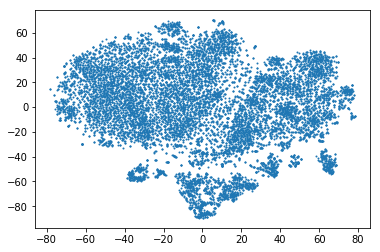

In [126]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne=TSNE()
%time d2vecs = tsne.fit_transform(embeddings)
plt.scatter(d2vecs[:, 0], d2vecs[:, 1], s=1)

# Clustering

Wall time: 7.41 s


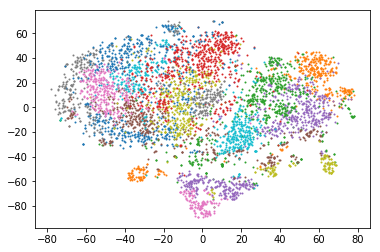

In [127]:
import numpy as np
from sklearn.mixture import GaussianMixture
n_topics = 20
gmm = GaussianMixture(n_components=n_topics, covariance_type='diag')

%time gmm.fit(embeddings[:5000])
topic_assignment = gmm.predict(embeddings[:5000])

indices = np.where(topic_assignment==1)[0]
center = np.array(embeddings)[indices].mean(axis=0)

for i in range(n_topics):
    indices = np.where(topic_assignment==i)[0]
    vecs = d2vecs[indices]
    plt.scatter(vecs[:, 0], vecs[:, 1], s=1)
    

In [128]:
cluster_centers=list()
for i in range(n_topics):
   # print(i)
    indices = np.where(topic_assignment==i)[0]
    center = np.array(embeddings)[indices].mean(axis=0)
    cluster_centers.append(center)

In [129]:
# Choose topic number and number of words should be used for the word cloud 
topic_number= 7
words_topic=100
res_topic=[]
for res in results[topic_number]:
    res_topic.append(res)

d ={'word': list(vocab), 'cosine_sim': res_topic}
topic_df = pd.DataFrame(data=d)

topic_sorted = topic_df.sort_values(by=['cosine_sim'],ascending=False)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = topic_sorted['word'][0:words_topic].tolist()
text = ', '.join(text)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

ValueError: arrays must all be same length

# LDA

In [132]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

tf =TfidfVectorizer()
lda = LatentDirichletAllocation(n_topics)

%time tfvecs = tf.fit_transform(newsgroups_train['data'][:1000])
%time lda_vecs = lda.fit_transform(tfvecs)


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

n_top_words=10
print("\nTopics in LDA model:")
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Wall time: 205 ms
Wall time: 2.01 s

Topics in LDA model:
Topic #0: idx accelerations wpi intercon umeister kurt njd cwikla amanda askew
Topic #1: amino jan acid glutamate landis essential 2600 dg color nicho
Topic #2: ax nuclear cooling nc towers board ncr tinnitus scope wa3wbu
Topic #3: den demers streak rick icons tosspot sewing p3 ucsd p2
Topic #4: scsi cleveland love oracle self turbo ___ tv body freenet
Topic #5: umn colostate bontchev uwm hamburg seth cs1442aq qazi acpub bk
Topic #6: mydisplay jb durham reed gifford gc split birthday advtech movies
Topic #7: henry launch shuttle values double ram toronto cost ti moon
Topic #8: indiana harris absolute women objective league argic goal serdar knew
Topic #9: borland stereo wkuvx1 movie gak flyers qazi joel brunel network
Topic #10: tmc brocku spartan pp pilon period mower breathing eisa toronto
Topic #11: csir manes uv tiff gtoal detroit metrics flyers gm ics
Topic #12: the to of and in is that it you edu
Topic #13: tis audio sylva